# **Trabalho de Conclusão de Curso Master BI - PUC RJ **

Aluno: Richard Peters

Turma: 2019.4


O objetivo deste trabalho é avaliar a base de dados de uma empresa de Óleo e Gás a qual deseja ser capaz de categorizar os tipos de falhas em seus poços, através dos 170 dados de sensores, entre "Superfície" (Surface) e "Fundo" (Downhole). A partir do algoritmo deste trabalho, a empresa será capaz de planejar de forma otimizada a disponibilidade de recursos necessários para intervenção e correção de uma nova falha, pois cada um dos cenários possuem distintas necessidades de equipamentos, equipe e investimentos. 

# 1.0 - Inicialização do Algoritmo


In [ ]:
import pandas as pd
import numpy as np
import csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
workdir_path = '/content/drive/My Drive/PUC/TCC'  
os.chdir(workdir_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2.0 - Análise Exploratória da Base de Dados

In [ ]:
## Cria a base de dados a partir do arquivo ".csv".

ref_df = pd.read_csv('equip_failures_training_set.csv', header = None)
ref_df

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171
0,id,target,sensor1_measure,sensor2_measure,sensor3_measure,sensor4_measure,sensor5_measure,sensor6_measure,sensor7_histogram_bin0,sensor7_histogram_bin1,sensor7_histogram_bin2,sensor7_histogram_bin3,sensor7_histogram_bin4,sensor7_histogram_bin5,sensor7_histogram_bin6,sensor7_histogram_bin7,sensor7_histogram_bin8,sensor7_histogram_bin9,sensor8_measure,sensor9_measure,sensor10_measure,sensor11_measure,sensor12_measure,sensor13_measure,sensor14_measure,sensor15_measure,sensor16_measure,sensor17_measure,sensor18_measure,sensor19_measure,sensor20_measure,sensor21_measure,sensor22_measure,sensor23_measure,sensor24_histogram_bin0,sensor24_histogram_bin1,sensor24_histogram_bin2,sensor24_histogram_bin3,sensor24_histogram_bin4,sensor24_histogram_bin5,...,sensor77_measure,sensor78_measure,sensor79_measure,sensor80_measure,sensor81_measure,sensor82_measure,sensor83_measure,sensor84_measure,sensor85_measure,sensor86_measure,sensor87_measure,sensor88_measure,sensor89_measure,sensor90_measure,sensor91_measure,sensor92_measure,sensor93_measure,sensor94_measure,sensor95_measure,sensor96_measure,sensor97_measure,sensor98_measure,sensor99_measure,sensor100_measure,sensor101_measure,sensor102_measure,sensor103_measure,sensor104_measure,sensor105_histogram_bin0,sensor105_histogram_bin1,sensor105_histogram_bin2,sensor105_histogram_bin3,sensor105_histogram_bin4,sensor105_histogram_bin5,sensor105_histogram_bin6,sensor105_histogram_bin7,sensor105_histogram_bin8,sensor105_histogram_bin9,sensor106_measure,sensor107_measure
1,1,0,76698,na,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,...,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.8,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
2,2,0,33058,na,0,na,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,0,71510,...,na,na,3312,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
3,3,0,41040,na,228,100,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,0,0,...,0,2341048,1494,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
4,4,0,12,0,70,66,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,0,0,...,0,2578,76,62,0,0,0,0,0,0,0,0,232,0,0,2014,370,48,18,15740,1822,20174,44,0,0,0,1.08,54,5670,1566,240,46,58,44,10,0,0,0,4,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59996,59996,0,153002,na,664,186,0,0,0,0,0,2564,59100,1603216,6015982,1968266,164972,12560,4880368,0,280,0,1224,2114,8913782,7998174,1929126,776370,2,0,0,0,3328,1080,0,0,0,0,0,45114,...,0,1872932,4936,1600,0,0,0,0,0,0,0,0,62846,137050,27546,0,0,265640,54496,470800,293652,0,0,0,0,80125300,2912.04,2858,1608808,1479066,998500,566884,1290398,1218244,1019768,717762,898642,28588,0,0
59997,59997,0,2286,na,2130706538,224,0,0,0,0,0,0,104,99186,36564,128,0,0,56982,0,0,0,0,0,123604,108768,24020,11622,0,0,0,0,192,56,0,0,0,0,0,4610,...,10,124152,114,56,0,0,0,0,0,0,0,0,1066,808,600,0,0,2450,510,823720,82346,16440,20,0,0,

In [ ]:
## Remove a coluna ID.

ref_df = ref_df.drop(columns=0)
ref_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171
0,target,sensor1_measure,sensor2_measure,sensor3_measure,sensor4_measure,sensor5_measure,sensor6_measure,sensor7_histogram_bin0,sensor7_histogram_bin1,sensor7_histogram_bin2,sensor7_histogram_bin3,sensor7_histogram_bin4,sensor7_histogram_bin5,sensor7_histogram_bin6,sensor7_histogram_bin7,sensor7_histogram_bin8,sensor7_histogram_bin9,sensor8_measure,sensor9_measure,sensor10_measure,sensor11_measure,sensor12_measure,sensor13_measure,sensor14_measure,sensor15_measure,sensor16_measure,sensor17_measure,sensor18_measure,sensor19_measure,sensor20_measure,sensor21_measure,sensor22_measure,sensor23_measure,sensor24_histogram_bin0,sensor24_histogram_bin1,sensor24_histogram_bin2,sensor24_histogram_bin3,sensor24_histogram_bin4,sensor24_histogram_bin5,sensor24_histogram_bin6,...,sensor77_measure,sensor78_measure,sensor79_measure,sensor80_measure,sensor81_measure,sensor82_measure,sensor83_measure,sensor84_measure,sensor85_measure,sensor86_measure,sensor87_measure,sensor88_measure,sensor89_measure,sensor90_measure,sensor91_measure,sensor92_measure,sensor93_measure,sensor94_measure,sensor95_measure,sensor96_measure,sensor97_measure,sensor98_measure,sensor99_measure,sensor100_measure,sensor101_measure,sensor102_measure,sensor103_measure,sensor104_measure,sensor105_histogram_bin0,sensor105_histogram_bin1,sensor105_histogram_bin2,sensor105_histogram_bin3,sensor105_histogram_bin4,sensor105_histogram_bin5,sensor105_histogram_bin6,sensor105_histogram_bin7,sensor105_histogram_bin8,sensor105_histogram_bin9,sensor106_measure,sensor107_measure
1,0,76698,na,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,...,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.8,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
2,0,33058,na,0,na,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,0,71510,772720,...,na,na,3312,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
3,0,41040,na,228,100,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,0,0,870456,...,0,2341048,1494,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
4,0,12,0,70,66,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,0,0,0,...,0,2578,76,62,0,0,0,0,0,0,0,0,232,0,0,2014,370,48,18,15740,1822,20174,44,0,0,0,1.08,54,5670,1566,240,46,58,44,10,0,0,0,4,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59996,0,153002,na,664,186,0,0,0,0,0,2564,59100,1603216,6015982,1968266,164972,12560,4880368,0,280,0,1224,2114,8913782,7998174,1929126,776370,2,0,0,0,3328,1080,0,0,0,0,0,45114,2533260,...,0,1872932,4936,1600,0,0,0,0,0,0,0,0,62846,137050,27546,0,0,265640,54496,470800,293652,0,0,0,0,80125300,2912.04,2858,1608808,1479066,998500,566884,1290398,1218244,1019768,717762,898642,28588,0,0
59997,0,2286,na,2130706538,224,0,0,0,0,0,0,104,99186,36564,128,0,0,56982,0,0,0,0,0,123604,108768,24020,11622,0,0,0,0,192,56,0,0,0,0,0,4610,99120,...,10,124152,114,56,0,0,0,0,0,0,0,0,1066,808,600

In [ ]:
## Remove primeira linha (antigo header).

ref_df = ref_df.drop(axis = 0,index = 0)
ref_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171
1,0,76698,na,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,...,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.8,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
2,0,33058,na,0,na,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,0,71510,772720,...,na,na,3312,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
3,0,41040,na,228,100,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,0,0,870456,...,0,2341048,1494,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
4,0,12,0,70,66,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,0,0,0,...,0,2578,76,62,0,0,0,0,0,0,0,0,232,0,0,2014,370,48,18,15740,1822,20174,44,0,0,0,1.08,54,5670,1566,240,46,58,44,10,0,0,0,4,32
5,0,60874,na,1368,458,0,0,0,0,0,0,43752,1966618,1800340,131646,4588,0,1974038,0,226,0,0,0,3230626,2618878,1058136,551022,0,0,0,0,1788,642,0,0,0,0,42124,372236,2128914,...,0,3590004,2026,444,0,0,0,0,0,0,0,0,44946,62648,11506,0,0,149474,35154,457040,80482,98334,27588,0,0,21173050,1116.06,1176,404740,904230,622012,229790,405298,347188,286954,311560,433954,1218,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59996,0,153002,na,664,186,0,0,0,0,0,2564,59100,1603216,6015982,1968266,164972,12560,4880368,0,280,0,1224,2114,8913782,7998174,1929126,776370,2,0,0,0,3328,1080,0,0,0,0,0,45114,2533260,...,0,1872932,4936,1600,0,0,0,0,0,0,0,0,62846,137050,27546,0,0,265640,54496,470800,293652,0,0,0,0,80125300,2912.04,2858,1608808,1479066,998500,566884,1290398,1218244,1019768,717762,898642,28588,0,0
59997,0,2286,na,2130706538,224,0,0,0,0,0,0,104,99186,36564,128,0,0,56982,0,0,0,0,0,123604,108768,24020,11622,0,0,0,0,192,56,0,0,0,0,0,4610,99120,...,10,124152,114,56,0,0,0,0,0,0,0,0,1066,808,600,0,0,2450,510,823720,82346,16440,20,0,0,1285980,80.4,82,13934,15024,10578,6760,21126,68424,136,0,0,0,0,0
59998,0,112,0,2130706432,18,0,0,0,0,0,0,28,11592,11538,0,0,0,8784,0,0,0,0,0,29698,23762,13970,874,0,0,0,0,36,20,0,0,0,0,0,0,0,...,0,8864,148,74,0,7042,0,0,0,0,0,0,622,0,0,4544,2398,162,58,7920,784,9112,0,0,0,0,2.76,134,15876,2740,792,386,452,144,146,2622,0,0,0,0
59999,0,80292,na,2130706432,494,0,0,0,0,0,0,330,202498,3251010,2061456,360436,59754,2634394,0,0,0,0,0,4543410,3227856,1615634,1214970,0,0,57300,0,2124,1090,0,0,0,0,0,119742,4445146,...,22,4858834,5598,284,0,0,190,106152,0,0,0,0,79230,37162,18388,0,0,166748,40564,25232340,5648346,0,0,0,0,39881280,1659.7,1908,1180714,1709450,699352,222654,347378,225724,194440,165070,802280,388422,0,0


In [ ]:
## Como alguns dados não são numéricos, por exemplo os 'na', o programa mostra como se não houvesse incidência de valores nulos/vazios.

NAN = ref_df.isna().sum()
NAN

1      0
2      0
3      0
4      0
5      0
      ..
167    0
168    0
169    0
170    0
171    0
Length: 171, dtype: int64

In [ ]:
## Garante que todos os dados são numéricos, e trata aqueles que não conseguiram ser interpretados.

ref_df = ref_df.apply(pd.to_numeric, errors='coerce')

In [ ]:
## Uma vez que os dados foram tratados na linha anterior, podemos ter uma noção de quantidade de dados "ausentes" na base, os quais podem fazer com que um atributo não seja representativo para o treinamento da base.

NAN1 = ref_df.isna().sum()
NAN1.values

array([    0,     0, 46329,  3335, 14861,  2500,  2500,   671,   671,
         671,   671,   671,   671,   671,   671,   671,   671,   645,
         629,   629,  4400,   642,   629,   642,   589,   642,   589,
        2723,   629,   629,   629,  2500,  2501,   671,   671,   671,
         671,   671,   671,   671,   671,   671,   671,   671,   671,
         671,   671,   671,   671,   671,   671,   671,   671,   688,
         688,   688,   688,   688,   688,   688,   688,   688,   688,
         645,  2725,  2727,  2503,  2500,   642,   642,   589,   589,
       23034, 27277, 39549, 44009, 46333, 47740, 48722, 49264,   726,
         167,   691,   691,  3257,   473,  2723,  4356,   726,  3255,
         676,  2502, 14861, 14861, 14861,   338,   338,   338,  9553,
        9877,   687,   687,   687,   687,   687,   687,   687,   687,
         687,   687, 14861,  2724,   691, 46329,   669,   669,   669,
         669,   669,   669,   669,   669,   669,   669, 13808, 13808,
       13808, 13808,

In [ ]:
## Identificamos a porcentagem de na/NAN que temos em cada atributo em relação ao total de dados daquele atributo.

percent_NAN = (NAN1.values/60000)*100
percent_NAN

array([ 0.        ,  0.        , 77.215     ,  5.55833333, 24.76833333,
        4.16666667,  4.16666667,  1.11833333,  1.11833333,  1.11833333,
        1.11833333,  1.11833333,  1.11833333,  1.11833333,  1.11833333,
        1.11833333,  1.11833333,  1.075     ,  1.04833333,  1.04833333,
        7.33333333,  1.07      ,  1.04833333,  1.07      ,  0.98166667,
        1.07      ,  0.98166667,  4.53833333,  1.04833333,  1.04833333,
        1.04833333,  4.16666667,  4.16833333,  1.11833333,  1.11833333,
        1.11833333,  1.11833333,  1.11833333,  1.11833333,  1.11833333,
        1.11833333,  1.11833333,  1.11833333,  1.11833333,  1.11833333,
        1.11833333,  1.11833333,  1.11833333,  1.11833333,  1.11833333,
        1.11833333,  1.11833333,  1.11833333,  1.14666667,  1.14666667,
        1.14666667,  1.14666667,  1.14666667,  1.14666667,  1.14666667,
        1.14666667,  1.14666667,  1.14666667,  1.075     ,  4.54166667,
        4.545     ,  4.17166667,  4.16666667,  1.07      ,  1.07

In [ ]:
## Retorna o valor da maior porcentagem de valores nulos em um único atributo da base.

percent_NAN.max()

82.10666666666665

In [ ]:
## Indentifica quais colunas possuem quantidade de NAN acima de 30% de seu total.

dp = percent_NAN
dp = dp>30
dp

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [ ]:
## Remove as colunas com % de NAN superior a 30%

i=0
j=0
while i < 171:
  if dp[i] == True:
      col = i+1
      ref_df = ref_df.drop(columns=col)
      j+=1
      i+=1
      print('i=',i)
      print('j=',j);
  else:
      i+=1;
      print('i=',i)
;

ref_df

i= 1
i= 2
i= 3
j= 1
i= 4
i= 5
i= 6
i= 7
i= 8
i= 9
i= 10
i= 11
i= 12
i= 13
i= 14
i= 15
i= 16
i= 17
i= 18
i= 19
i= 20
i= 21
i= 22
i= 23
i= 24
i= 25
i= 26
i= 27
i= 28
i= 29
i= 30
i= 31
i= 32
i= 33
i= 34
i= 35
i= 36
i= 37
i= 38
i= 39
i= 40
i= 41
i= 42
i= 43
i= 44
i= 45
i= 46
i= 47
i= 48
i= 49
i= 50
i= 51
i= 52
i= 53
i= 54
i= 55
i= 56
i= 57
i= 58
i= 59
i= 60
i= 61
i= 62
i= 63
i= 64
i= 65
i= 66
i= 67
i= 68
i= 69
i= 70
i= 71
i= 72
i= 73
j= 2
i= 74
j= 3
i= 75
j= 4
i= 76
j= 5
i= 77
j= 6
i= 78
j= 7
i= 79
j= 8
i= 80
j= 9
i= 81
i= 82
i= 83
i= 84
i= 85
i= 86
i= 87
i= 88
i= 89
i= 90
i= 91
i= 92
i= 93
i= 94
i= 95
i= 96
i= 97
i= 98
i= 99
i= 100
i= 101
i= 102
i= 103
i= 104
i= 105
i= 106
i= 107
i= 108
i= 109
i= 110
i= 111
i= 112
i= 113
i= 114
j= 10
i= 115
i= 116
i= 117
i= 118
i= 119
i= 120
i= 121
i= 122
i= 123
i= 124
i= 125
i= 126
i= 127
i= 128
i= 129
i= 130
i= 131
i= 132
i= 133
i= 134
i= 135
i= 136
i= 137
i= 138
i= 139
i= 140
i= 141
i= 142
i= 143
i= 144
i= 145
i= 146
i= 147
i= 148
i= 149
i= 150
i= 151


,1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,...,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171
1,0,76698,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,0.0,37250.0,1432864.0,3664156.0,1007684.0,25896.0,0.0,2551696.0,0.0,0.0,0.0,0.0,0.0,4933296.0,3655166.0,1766008.0,1132040.0,0.0,0.0,0.0,0.0,1012.0,268.0,0.0,0.0,0.0,0.0,0.0,469014.0,4239660.0,703300.0,...,18.0,5330690.0,4732.0,1126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62282.0,85908.0,32790.0,0.0,0.0,202710.0,37928.0,14745580.0,1876644.0,0.0,0.0,0.0,0.0,2801180.0,2445.80,2712.0,965866.0,1706908.0,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
2,0,33058,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,18254.0,653294.0,1720800.0,516724.0,31642.0,0.0,1393352.0,0.0,68.0,0.0,0.0,0.0,2560898.0,2127150.0,1084598.0,338544.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71510.0,772720.0,1996924.0,...,NaN,NaN,3312.0,522.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33736.0,36946.0,5936.0,0.0,0.0,103330.0,16254.0,4510080.0,868538.0,0.0,0.0,0.0,0.0,3477820.0,2211.76,2334.0,664504.0,824154.0,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
3,0,41040,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,0.0,1648.0,370592.0,1883374.0,292936.0,12016.0,0.0,1234132.0,0.0,0.0,0.0,0.0,0.0,2371990.0,2173634.0,300796.0,153698.0,0.0,0.0,0.0,0.0,358.0,110.0,0.0,0.0,0.0,0.0,0.0,0.0,870456.0,239798.0,...,0.0,2341048.0,1494.0,152.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13876.0,38182.0,8138.0,0.0,0.0,65772.0,10534.0,300240.0,48028.0,0.0,0.0,0.0,0.0,1040120.0,1018.64,1020.0,262032.0,453378.0,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
4,0,12,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,318.0,2212.0,3232.0,1872.0,0.0,0.0,0.0,2668.0,0.0,0.0,0.0,642.0,3894.0,10184.0,7554.0,10764.0,1014.0,0.0,0.0,0.0,0.0,60.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2038.0,...,0.0,2578.0,76.0,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,232.0,0.0,0.0,2014.0,370.0,48.0,18.0,15740.0,1822.0,20174.0,44.0,0.0,0.0,0.0,1.08,54.0,5670.0,1566.0,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
5,0,60874,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,0.0,43752.0,1966618.0,1800340.0,131646.0,4588.0,0.0,1974038.0,0.0,226.0,0.0,0.0,0.0,3230626.0,2618878.0,1058136.0,551022.0,0.0,0.0,0.0,0.0,1788.0,642.0,0.0,0.0,0.0,0.0,42124.0,372236.0,2128914.0,819596.0,...,0.0,3590004.0,2026.0,444.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44946.0,62648.0,11506.0,0.0,0.0,149474.0,35154.0,457040.0,80482.0,98334.0,27588.0,0.0,0.0,21173050.0,1116.06,1176.0,404740.0,904230.0,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59996,0,153002,6.640000e+02,186.0,0.0,0.0,0.0,0.0,0.0,2564.0,59100.0,1603216.0,6015982.0,1968266.0,164972.0,12560.0,4880368.0,0.0,280.0,0.0,1224.0,2114.0,8913782.0,7998174.0,1929126.0,776370.0,2.0,0.0,0.0,0.0,3328.0,1080.0,0.0,0.0,0.0,0.0,0.0,45114.0,2533260.0,2542338.0,...,0.0,1872932.0,4936.0,1600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62846.0,137050.0,27546.0,0.0,0.0,265640.0,54496.0,470800.0,293652.0,0.0,0.0,0.0,0.0,80125300.0,2912.04,2858.0,1608808.0,1479066.0,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0
59997,0,2286,2.130707e+09,224.0,0.0,0.0,0.0,0.0,0.0,0.0,104.0,99186.0,36564.0,128.0,0.0,0.0,56982.0,0.0,0.0,0.0,0.0,0.0,123604.0,108768.0,24020.0,11622.0,0.0,0.0,0.0,0.0,192.0,56.0,0.0,0.0,0.0,0.0,0.0,4610.0,99120.0,11292.0,...,10.0,124152.0,114.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1066.0,808.0,600.0,0.0,0.0,2450.0,510.0,823720.0,82346.0,16440.0,20.0,0.0,0.0,1285980.0,80.40,82.0,13934

In [ ]:
## Reseta os indexes do dataframe para garantir que não existem "buracos" na lista de dados.

ref_df.reset_index(drop = True)

,1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,...,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171
0,0,76698,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,0.0,37250.0,1432864.0,3664156.0,1007684.0,25896.0,0.0,2551696.0,0.0,0.0,0.0,0.0,0.0,4933296.0,3655166.0,1766008.0,1132040.0,0.0,0.0,0.0,0.0,1012.0,268.0,0.0,0.0,0.0,0.0,0.0,469014.0,4239660.0,703300.0,...,18.0,5330690.0,4732.0,1126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62282.0,85908.0,32790.0,0.0,0.0,202710.0,37928.0,14745580.0,1876644.0,0.0,0.0,0.0,0.0,2801180.0,2445.80,2712.0,965866.0,1706908.0,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,0,33058,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,18254.0,653294.0,1720800.0,516724.0,31642.0,0.0,1393352.0,0.0,68.0,0.0,0.0,0.0,2560898.0,2127150.0,1084598.0,338544.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71510.0,772720.0,1996924.0,...,NaN,NaN,3312.0,522.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33736.0,36946.0,5936.0,0.0,0.0,103330.0,16254.0,4510080.0,868538.0,0.0,0.0,0.0,0.0,3477820.0,2211.76,2334.0,664504.0,824154.0,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,0,41040,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,0.0,1648.0,370592.0,1883374.0,292936.0,12016.0,0.0,1234132.0,0.0,0.0,0.0,0.0,0.0,2371990.0,2173634.0,300796.0,153698.0,0.0,0.0,0.0,0.0,358.0,110.0,0.0,0.0,0.0,0.0,0.0,0.0,870456.0,239798.0,...,0.0,2341048.0,1494.0,152.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13876.0,38182.0,8138.0,0.0,0.0,65772.0,10534.0,300240.0,48028.0,0.0,0.0,0.0,0.0,1040120.0,1018.64,1020.0,262032.0,453378.0,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,0,12,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,318.0,2212.0,3232.0,1872.0,0.0,0.0,0.0,2668.0,0.0,0.0,0.0,642.0,3894.0,10184.0,7554.0,10764.0,1014.0,0.0,0.0,0.0,0.0,60.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2038.0,...,0.0,2578.0,76.0,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,232.0,0.0,0.0,2014.0,370.0,48.0,18.0,15740.0,1822.0,20174.0,44.0,0.0,0.0,0.0,1.08,54.0,5670.0,1566.0,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,0,60874,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,0.0,43752.0,1966618.0,1800340.0,131646.0,4588.0,0.0,1974038.0,0.0,226.0,0.0,0.0,0.0,3230626.0,2618878.0,1058136.0,551022.0,0.0,0.0,0.0,0.0,1788.0,642.0,0.0,0.0,0.0,0.0,42124.0,372236.0,2128914.0,819596.0,...,0.0,3590004.0,2026.0,444.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44946.0,62648.0,11506.0,0.0,0.0,149474.0,35154.0,457040.0,80482.0,98334.0,27588.0,0.0,0.0,21173050.0,1116.06,1176.0,404740.0,904230.0,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,153002,6.640000e+02,186.0,0.0,0.0,0.0,0.0,0.0,2564.0,59100.0,1603216.0,6015982.0,1968266.0,164972.0,12560.0,4880368.0,0.0,280.0,0.0,1224.0,2114.0,8913782.0,7998174.0,1929126.0,776370.0,2.0,0.0,0.0,0.0,3328.0,1080.0,0.0,0.0,0.0,0.0,0.0,45114.0,2533260.0,2542338.0,...,0.0,1872932.0,4936.0,1600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62846.0,137050.0,27546.0,0.0,0.0,265640.0,54496.0,470800.0,293652.0,0.0,0.0,0.0,0.0,80125300.0,2912.04,2858.0,1608808.0,1479066.0,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0
59996,0,2286,2.130707e+09,224.0,0.0,0.0,0.0,0.0,0.0,0.0,104.0,99186.0,36564.0,128.0,0.0,0.0,56982.0,0.0,0.0,0.0,0.0,0.0,123604.0,108768.0,24020.0,11622.0,0.0,0.0,0.0,0.0,192.0,56.0,0.0,0.0,0.0,0.0,0.0,4610.0,99120.0,11292.0,...,10.0,124152.0,114.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1066.0,808.0,600.0,0.0,0.0,2450.0,510.0,823720.0,82346.0,16440.0,20.0,0.0,0.0,1285980.0,80.40,82.0,13934

In [ ]:
##  Nesta etapa, todos os campos "na" do dataframe são substituidos pela média dos valores do DF com a função "df.mean()", assim como outras definições.

ref_df = ref_df.fillna(ref_df.mean()) 

In [ ]:
## Dividindo o "df" entre treino e teste.
 

X = (ref_df.iloc[:,0:].values).astype('float32')
Y = (ref_df.iloc[:,0].values).astype('int32')

x_treino, x_teste, y_treino, y_verdadeiro = train_test_split(X, Y, test_size=0.15, random_state=10)

In [ ]:
## Normalizando os dados.
 
scaler = MinMaxScaler()
x_treino = scaler.fit_transform(x_treino)
x_treino = scaler.transform(x_treino)
x_teste = scaler.transform(x_teste)
x_treino.shape

(51000, 161)

# 3.0 - Treino e Teste do Modelo

In [ ]:
## Cria, treina e testa o modelo de predição.

rf_model = RandomForestClassifier()
rf_model.fit(x_treino, y_treino)
rf_model.score(x_treino, y_treino)
y_predict = rf_model.predict(x_teste)


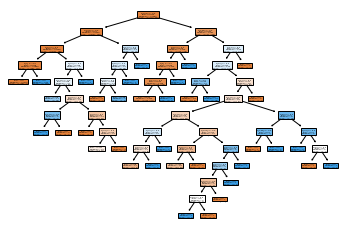

In [ ]:
## Salva gráfico da primeira DT da RF. 

plt.figure()
tree.plot_tree(rf_model.estimators_[0],label ='all', filled=True)  
plt.savefig('RF_norm',format='jpeg', dpi = 300)

# 4.0 Validação da Performance do Modelo

In [ ]:
## Valida o resultado do modelo (predição) quando comparado com o valor real esperado.

precision_recall_fscore_support(y_verdadeiro, y_predict, average='macro')


(0.9998870439399073, 0.9932885906040269, 0.9965651372113189, None)

In [ ]:
## Salva resultados em arquivos ".csv".

print1 = pd.DataFrame(y_verdadeiro, columns=['result'])
print2 = pd.DataFrame(y_predict, columns=['result'])

print1.to_csv(path_or_buf='y_verdadeiro_RF_norm.csv', index=True, header=True)
print2.to_csv(path_or_buf='y_predict_RF_norm.csv', index=True, header=True)